In [1]:
import pandas as pd
import numpy as np
import os

import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10 
import torchvision.transforms as transforms
from model import CNNModel 

In [2]:
cifar_data_root = '/media/analyze/datasets'
batch_size = 64
epochs = 10

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor      (),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5 ))]
)

In [4]:
train_data = CIFAR10(root=cifar_data_root, download=True, train=True, transform=transform) 
test_data = CIFAR10(root=cifar_data_root, download=True, train=False, transform=transform) 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = CNNModel()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [7]:
for epoch in range(epochs):
    epoch_loss =  0
    correct = 0
    total = 0
    for i, samples in enumerate(train_loader):
        data, labels = samples
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, labels) 
        epoch_loss += loss.item()
        
        predicted = outputs.max(1, keepdim=True)[1]
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        total += labels.size(0)
        
        loss.backward()
        optimizer.step()
    print('{} epoch: Loss {}, Accuracy {}'.format((epoch+1),
                               epoch_loss / len(train_loader),
                               correct / total
                               ))

/home/sasatani/PycharmProjects/Machine-Learning/GradCam/model.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


1 epoch: Loss 2.7360229917499415, Accuracy 0.37768
2 epoch: Loss 2.161033087221863, Accuracy 0.499
3 epoch: Loss 2.0919265390357094, Accuracy 0.52192
4 epoch: Loss 2.0525171471678694, Accuracy 0.5376
5 epoch: Loss 2.0235828431061162, Accuracy 0.54304
6 epoch: Loss 2.0094025200590147, Accuracy 0.55016
7 epoch: Loss 2.002900863547459, Accuracy 0.54976
8 epoch: Loss 1.9898708903271218, Accuracy 0.55752
9 epoch: Loss 1.979467079691265, Accuracy 0.55962
10 epoch: Loss 1.97369637071629, Accuracy 0.55934


##  GradCAM

In [8]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys

In [9]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [10]:
feature_fn = torch.nn.Sequential(*list(model.children())[:-2]).cpu()
classfier_fn = torch.nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()]
                                    + list(model.children())[-1:]
                                    )).cpu()

In [11]:
def GradCam(img, c, feature_fn, classifier_fn):
    feats = feature_fn(img.cpu())
    _, N, H, W = feats.size()
    out = classifier_fn(feats.view(feats.size(0), -1))
    c_score = out[0, c]
    print(c_score)
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = F.relu(sal)
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal

In [12]:
input_index = 15
input_data = test_loader.dataset[input_index][0]
input_data = input_data.view(1, input_data.shape[0], input_data.shape[1], input_data.shape[2]).cpu()

In [13]:
pp, cc = torch.topk(nn.Softmax(dim=1)(model(input_data)), 2)

/home/sasatani/PycharmProjects/Machine-Learning/GradCam/model.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


In [14]:
sal = GradCam(input_data.cpu(), cc[0][0], feature_fn, classfier_fn)

tensor(1682.0996, grad_fn=<SelectBackward>)


In [15]:
img = input_data.permute(0, 2, 3, 1).view(input_data.shape[2], input_data.shape[3], input_data.shape[1]).cpu().numpy()

In [16]:
img_sal = Image.fromarray(sal).resize(img.shape[0:2], resample=Image.LINEAR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


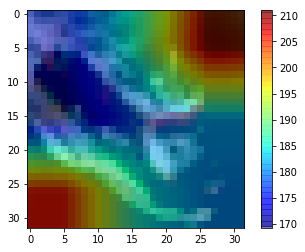

In [17]:
plt.imshow(img)
plt.imshow(np.array(img_sal), alpha=0.5, cmap="jet")
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


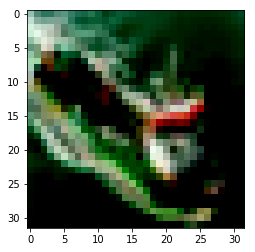

In [18]:
plt.imshow(img)